# Análise do Impacto dos Juros no Comportamento de Consumo  
## Integração de Dados Olist e Indicadores Macroeconômicos

Este notebook tem como objetivo investigar a relação entre variáveis macroeconômicas — 
em especial taxas de juros — e o comportamento de consumo observado na base de dados da Olist.

A análise será conduzida a partir da integração entre:

- Uma base de dados de **pedidos da Olist**, previamente tratada e agregada ao nível mensal,
  segmentada por **categoria dominante de produto** e restrita a compras realizadas via crédito;
- Uma base de **indicadores econômicos**, contendo informações sobre taxa Selic, inflação
  e custo real do crédito.

O foco do estudo é responder às seguintes questões:

- Existe correlação entre juros e valor dos pedidos ao longo do tempo?
- O uso do crédito (parcelamento) se altera conforme o nível de juros?
- Quais categorias de produtos demonstram maior sensibilidade às variações nas taxas de juros?

Este notebook parte de dados já explorados e tratados em uma etapa anterior, concentrando-se
exclusivamente na **análise integrada e interpretativa** entre consumo e macroeconomia.


In [26]:
# Ajuste de path para importar utilidades do projeto
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual padronizada do projeto
from utils.viz_config import PALETA_OLIST

# Configurações gerais
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

sns.set_theme(style="whitegrid")


## Importação das Bases de Dados

Serão carregadas duas bases principais:

1. **Base Olist tratada**, agregada mensalmente por categoria de produto dominante,
   contendo métricas de valor de pedido, volume de vendas e parcelamento.
2. **Base de indicadores macroeconômicos**, contendo informações sobre taxa de juros,
   inflação e custo real do crédito, também em frequência mensal.

Ambas as bases utilizam a coluna `Date` como chave temporal para posterior integração.


In [27]:


# Base Olist preparada para cruzamento macroeconômico
olist = pd.read_csv(
    '../../dados/olist_agregada_mes.csv',
    parse_dates=['Date']
)

# Base de indicadores macroeconômicos
macro = pd.read_csv(
    '../../dados/dados_economicos.csv',
    parse_dates=['Date']
)

# Visualização inicial
display(olist.head())
display(macro.head())


,Date,product_category_name,total_pedidos,ticket_medio,ticket_mediana,parcelas_media,parcelas_mediana,faturamento_total
0,2016-09-01,moveis_decoracao,1,72.89,72.89,1.00,1.00,72.89
1,2016-09-01,telefonia,1,59.50,59.50,3.00,3.00,59.50
2,2016-10-01,alimentos,1,79.90,79.90,1.00,1.00,79.90
3,2016-10-01,audio,1,132.00,132.00,3.00,3.00,132.00
4,2016-10-01,automotivo,10,182.32,106.75,4.60,4.00,"1,823.25"


,Date,juros_base_selic,previsao_inflacao_12m,inflacao_realizada_12m,custo_real_esperado,custo_real_efetivo,juros_base_selic_std,previsao_inflacao_12m_std,inflacao_realizada_12m_std,custo_real_esperado_std,custo_real_efetivo_std
0,2016-01-01,14.25,7.05,10.71,6.72,3.20,1.19,2.46,2.04,0.57,-0.86
1,2016-02-01,14.25,6.97,10.36,6.80,3.52,1.19,2.38,1.91,0.61,-0.68
2,2016-03-01,14.25,6.66,9.39,7.12,4.44,1.19,2.04,1.55,0.74,-0.17
3,2016-04-01,14.25,6.33,9.28,7.45,4.55,1.19,1.69,1.50,0.87,-0.12
4,2016-05-01,14.25,6.08,9.32,7.70,4.51,1.19,1.44,1.52,0.98,-0.14


## Verificação Estrutural

Antes da integração das bases, é importante validar:

- Intervalo temporal coberto por cada base;
- Consistência das colunas de data;
- Ausência de duplicidades inesperadas;
- Compatibilidade da frequência temporal (mensal).

Essa verificação evita erros silenciosos durante o cruzamento dos dados.


In [28]:
print('Base Olist')
print('Período:', olist['Date'].min(), '→', olist['Date'].max())
print('Observações:', len(olist))
print()

print('Base Macroeconômica')
print('Período:', macro['Date'].min(), '→', macro['Date'].max())
print('Observações:', len(macro))


Base Olist
Período: 2016-09-01 00:00:00 → 2018-08-01 00:00:00
Observações: 1224

Base Macroeconômica
Período: 2016-01-01 00:00:00 → 2018-12-01 00:00:00
Observações: 36


## Seleção das Taxas de Juros

A análise utilizará diferentes medidas de taxa de juros, explorando tanto o efeito
da política monetária quanto o custo real do crédito percebido pelo consumidor.

- **Juros base (Selic)**: utilizada como indicador macroeconômico, refletindo a
  orientação geral da política monetária.
- **Custo real esperado do crédito**: representa o custo real do dinheiro considerando
  expectativas inflacionárias, sendo a principal variável explicativa do comportamento
  de consumo.
- **Custo real efetivo**: utilizado como variável de controle e validação analítica.

Essa abordagem permite avaliar tanto efeitos imediatos quanto defasados das alterações
nas condições monetárias sobre o comportamento do consumidor.


In [29]:
macro.columns


Index(['Date', 'juros_base_selic', 'previsao_inflacao_12m',
       'inflacao_realizada_12m', 'custo_real_esperado', 'custo_real_efetivo',
       'juros_base_selic_std', 'previsao_inflacao_12m_std',
       'inflacao_realizada_12m_std', 'custo_real_esperado_std',
       'custo_real_efetivo_std'],
      dtype='object')

In [30]:
macro_sel = macro[
    [
        'Date',
        'juros_base_selic',
        'custo_real_esperado',
        'custo_real_efetivo'
    ]
].copy()

macro_sel.head()


,Date,juros_base_selic,custo_real_esperado,custo_real_efetivo
0,2016-01-01,14.25,6.72,3.20
1,2016-02-01,14.25,6.80,3.52
2,2016-03-01,14.25,7.12,4.44
3,2016-04-01,14.25,7.45,4.55
4,2016-05-01,14.25,7.70,4.51


In [31]:
df_merged = (
    olist
    .merge(
        macro_sel,
        on='Date',
        how='left'
    )
)

df_merged.head()


,Date,product_category_name,total_pedidos,ticket_medio,ticket_mediana,parcelas_media,parcelas_mediana,faturamento_total,juros_base_selic,custo_real_esperado,custo_real_efetivo
0,2016-09-01,moveis_decoracao,1,72.89,72.89,1.00,1.00,72.89,14.25,8.57,5.32
1,2016-09-01,telefonia,1,59.50,59.50,3.00,3.00,59.50,14.25,8.57,5.32
2,2016-10-01,alimentos,1,79.90,79.90,1.00,1.00,79.90,14.15,8.70,5.82
3,2016-10-01,audio,1,132.00,132.00,3.00,3.00,132.00,14.15,8.70,5.82
4,2016-10-01,automotivo,10,182.32,106.75,4.60,4.00,"1,823.25",14.15,8.70,5.82


In [32]:
df_merged.isna().mean().sort_values(ascending=False)


Date                    0.00
product_category_name   0.00
total_pedidos           0.00
ticket_medio            0.00
ticket_mediana          0.00
parcelas_media          0.00
parcelas_mediana        0.00
faturamento_total       0.00
juros_base_selic        0.00
custo_real_esperado     0.00
custo_real_efetivo      0.00
dtype: float64

A base integrada permitirá responder às seguintes questões:

1. Qual a relação entre taxas de juros e o valor médio dos pedidos ao longo do tempo?
2. Como o custo real do crédito afeta o uso de parcelamento?
3. Existe defasagem temporal entre mudanças nos juros e o comportamento do consumidor?
4. Quais categorias de produtos apresentam maior sensibilidade às condições monetárias?


Nesta etapa, analisamos a correlação contemporânea entre variáveis macroeconômicas
(taxas de juros) e métricas de consumo da Olist.

O objetivo é identificar associações iniciais entre:
- custo do crédito
- valor dos pedidos
- uso de parcelamento

Esta análise não implica causalidade, servindo como base exploratória
para análises temporais mais avançadas.


In [33]:
corr_vars = df_merged[
    [
        'ticket_medio',
        'ticket_mediana',
        'parcelas_media',
        'parcelas_mediana',
        'faturamento_total',
        'juros_base_selic',
        'custo_real_esperado',
        'custo_real_efetivo'
    ]
].dropna()


In [34]:
corr_matrix = corr_vars.corr(method='pearson')

corr_matrix


,ticket_medio,ticket_mediana,parcelas_media,parcelas_mediana,faturamento_total,juros_base_selic,custo_real_esperado,custo_real_efetivo
ticket_medio,1.00,0.88,0.39,0.39,0.05,0.01,0.01,0.00
ticket_mediana,0.88,1.00,0.39,0.40,-0.00,0.03,0.03,0.03
parcelas_media,0.39,0.39,1.00,0.92,0.04,0.11,0.11,0.12
parcelas_mediana,0.39,0.40,0.92,1.00,-0.02,0.12,0.12,0.14
faturamento_total,0.05,-0.00,0.04,-0.02,1.00,-0.20,-0.20,-0.17
juros_base_selic,0.01,0.03,0.11,0.12,-0.20,1.00,1.00,0.87
custo_real_esperado,0.01,0.03,0.11,0.12,-0.20,1.00,1.00,0.88
custo_real_efetivo,0.00,0.03,0.12,0.14,-0.17,0.87,0.88,1.00


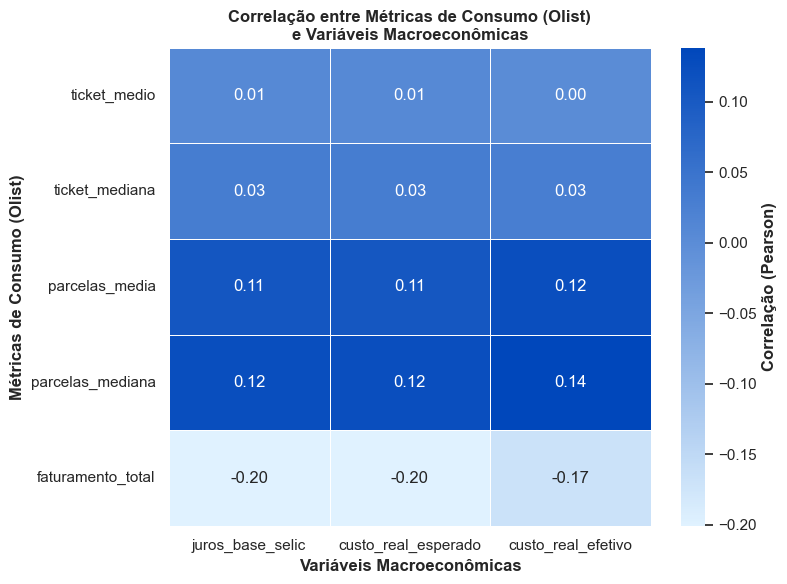

In [35]:
# ============================================================
# Heatmap de Correlação — Olist (linhas) × Macro (colunas)
# ============================================================

from matplotlib.colors import LinearSegmentedColormap

olist_vars = [
    'ticket_medio',
    'ticket_mediana',
    'parcelas_media',
    'parcelas_mediana',
    'faturamento_total'
]

macro_vars = [
    'juros_base_selic',
    'custo_real_esperado',
    'custo_real_efetivo'
]

# Submatriz direta (sem simetria redundante)
corr_matrix = (
    df_merged[olist_vars + macro_vars]
    .dropna()
    .corr(method='pearson')
    .loc[olist_vars, macro_vars]
)

# Colormap azul crescente (quanto mais intenso, maior |correlação|)
blue_cmap = LinearSegmentedColormap.from_list(
    'blue_intensity',
    ['#e0f2ff', PALETA_OLIST[0]]
)

plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap=blue_cmap,
    linewidths=0.6,
    cbar_kws={'label': 'Correlação (Pearson)'}
)

plt.title(
    'Correlação entre Métricas de Consumo (Olist)\n'
    'e Variáveis Macroeconômicas'
)

plt.ylabel('Métricas de Consumo (Olist)')
plt.xlabel('Variáveis Macroeconômicas')

plt.tight_layout()
plt.show()


### Relação entre Juros e Faturamento

Ao observar a matriz de correlação, nota-se que a maior parte das variáveis de consumo
(ticket médio, ticket mediano e número de parcelas) apresenta correlação fraca ou
praticamente nula com as variáveis macroeconômicas no período analisado.

Entretanto, destaca-se uma **correlação negativa moderada entre o faturamento total
e as taxas de juros** (Selic e custo real do crédito).

Esse resultado sugere que:
- O valor médio dos pedidos e a forma de parcelamento permanecem relativamente estáveis;
- O principal canal de impacto dos juros ocorre **via volume financeiro agregado**,
  indicando retração no consumo total em cenários de juros elevados.

Ou seja, o consumidor que decide comprar tende a manter padrões semelhantes de gasto,
mas **menos consumidores efetivamente realizam compras** quando o custo do crédito aumenta.

Dessa forma, as próximas análises focam em entender:
- Como o faturamento evolui ao longo do tempo em relação aos juros;
- Se existem defasagens temporais (lags) entre mudanças nas taxas e o impacto no consumo.


In [36]:
# Agregação mensal total (todas as categorias)
df_time = (
    df_merged
    .groupby('Date')
    .agg(
        faturamento_total=('faturamento_total', 'sum'),
        juros_base_selic=('juros_base_selic', 'mean')
    )
    .reset_index()
)

df_time.head()


,Date,faturamento_total,juros_base_selic
0,2016-09-01,132.39,14.25
1,2016-10-01,"41,612.06",14.15
2,2016-12-01,10.90,13.75
3,2017-01-01,"97,405.00",13.27
4,2017-02-01,"192,889.26",12.84


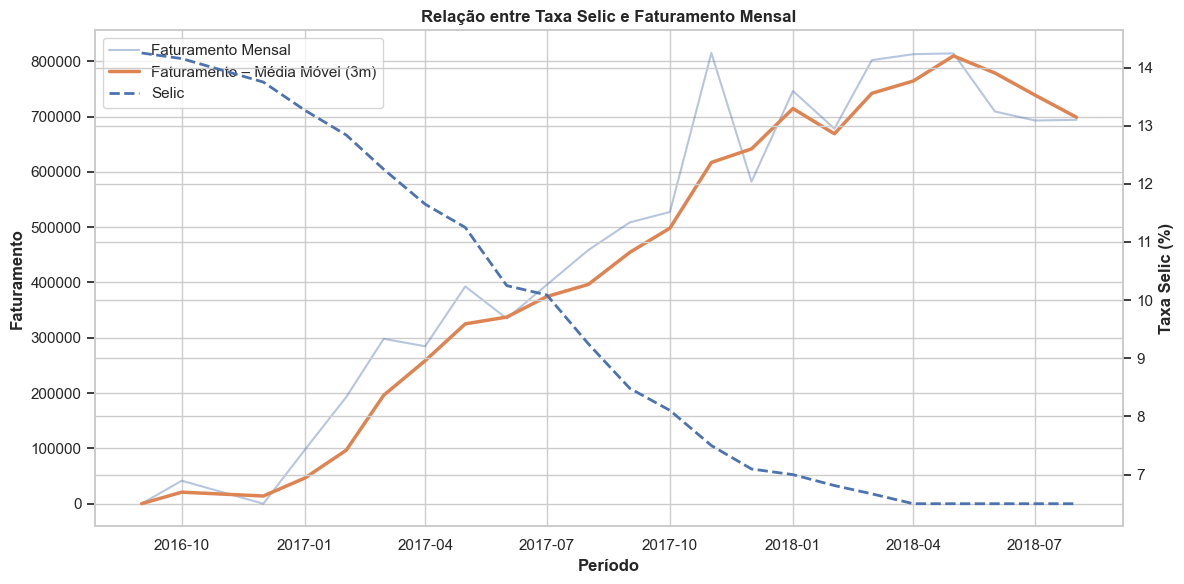

In [37]:
# =========================================================
# Juros (Selic) x Faturamento Mensal com Média Móvel
# =========================================================

# Agregar faturamento mensal total
df_time = (
    df_merged
    .groupby('Date', as_index=False)
    .agg({
        'faturamento_total': 'sum',
        'juros_base_selic': 'mean'
    })
    .sort_values('Date')
)

# Cálculo da média móvel (3 meses)
df_time['faturamento_mm_3m'] = (
    df_time['faturamento_total']
    .rolling(window=3, min_periods=1)
    .mean()
)

# Criação do gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Faturamento mensal
ax1.plot(
    df_time['Date'],
    df_time['faturamento_total'],
    label='Faturamento Mensal',
    alpha=0.4
)

# Média móvel do faturamento
ax1.plot(
    df_time['Date'],
    df_time['faturamento_mm_3m'],
    linewidth=2.5,
    label='Faturamento – Média Móvel (3m)'
)

ax1.set_ylabel('Faturamento')
ax1.set_xlabel('Período')

# Eixo secundário para Selic
ax2 = ax1.twinx()
ax2.plot(
    df_time['Date'],
    df_time['juros_base_selic'],
    linestyle='--',
    linewidth=2,
    label='Selic'
)

ax2.set_ylabel('Taxa Selic (%)')

# Legendas combinadas
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper left'
)

plt.title('Relação entre Taxa Selic e Faturamento Mensal')
plt.tight_layout()
plt.show()


### Faturamento Total e Política Monetária

O gráfico evidencia a evolução conjunta do faturamento total do e-commerce e da
taxa básica de juros (Selic) ao longo do tempo.

Observa-se que períodos de elevação da Selic tendem a coincidir com desaceleração
ou retração do faturamento agregado, enquanto momentos de flexibilização monetária
são acompanhados por recuperação do consumo.

Esse comportamento reforça os resultados observados na matriz de correlação:
o impacto dos juros se manifesta predominantemente no **volume financeiro total**
do mercado, e não no valor médio dos pedidos ou na forma de parcelamento.

A interpretação econômica sugere que o aumento do custo do crédito reduz a
quantidade de consumidores dispostos a comprar, enquanto aqueles que decidem
comprar mantêm padrões relativamente estáveis de gasto.


In [38]:
print(olist.head(3))
print(olist.dtypes)
print(olist['product_category_name'].unique())


        Date product_category_name  total_pedidos  ticket_medio  \
0 2016-09-01      moveis_decoracao              1         72.89   
1 2016-09-01             telefonia              1         59.50   
2 2016-10-01             alimentos              1         79.90   

   ticket_mediana  parcelas_media  parcelas_mediana  faturamento_total  
0           72.89            1.00              1.00              72.89  
1           59.50            3.00              3.00              59.50  
2           79.90            1.00              1.00              79.90  
Date                     datetime64[ns]
product_category_name            object
total_pedidos                     int64
ticket_medio                    float64
ticket_mediana                  float64
parcelas_media                  float64
parcelas_mediana                float64
faturamento_total               float64
dtype: object
['moveis_decoracao' 'telefonia' 'alimentos' 'audio' 'automotivo' 'bebes'
 'beleza_saude' 'brinquedos' 'ca

C:\Users\cauap\AppData\Local\Temp\ipykernel_59512\3730673825.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(


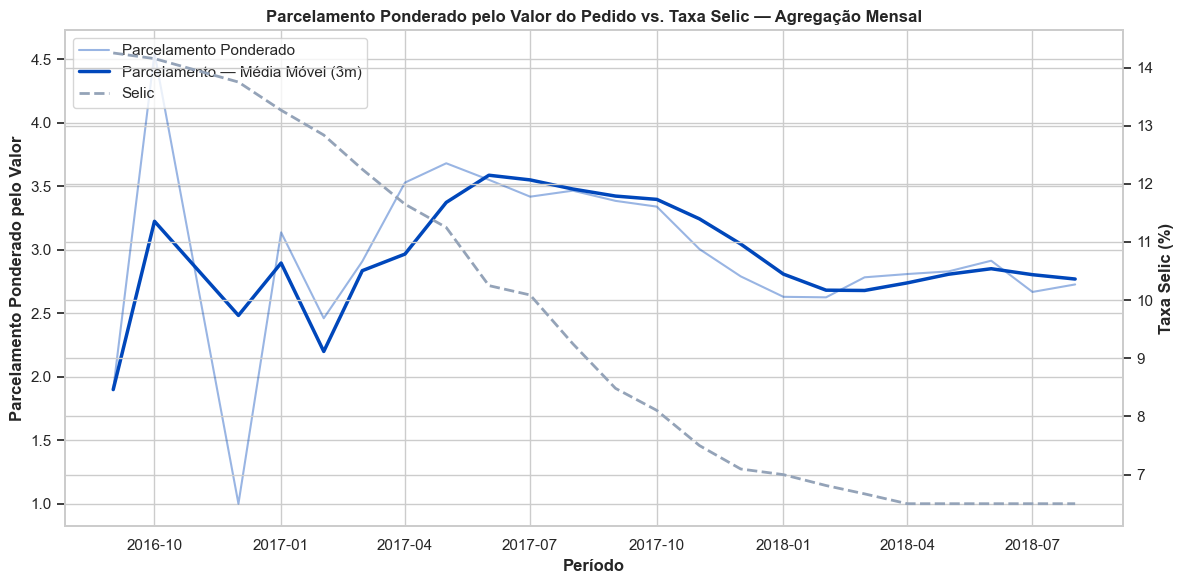

Correlação entre parcelamento ponderado e Selic:


,parcelas_ponderadas,juros_base_selic
parcelas_ponderadas,1.00,0.00
juros_base_selic,0.00,1.00


In [39]:
# =========================================================
# Parcelamento Ponderado pelo Valor do Pedido vs Selic
# =========================================================

# Agrupamento mensal, ponderando parcelas pelo valor do pedido
df_credito_weighted = (
    df_merged.groupby('Date')
    .apply(lambda x: np.average(
        x['parcelas_mediana'],  # número de parcelas
        weights=x['faturamento_total']  # ponderando pelo valor do pedido
    ))
    .to_frame(name='parcelas_ponderadas')  # transforma Series em DataFrame com nome da coluna
    .reset_index()  # reset do índice para colocar 'Date' como coluna normal
)

# Adiciona Selic mensal (mediana)
df_credito_weighted = df_credito_weighted.merge(
    df_merged.groupby('Date', as_index=False)['juros_base_selic'].median(),
    on='Date',
    how='left'
)

# Média móvel 3 meses para suavização
df_credito_weighted['parcelas_mm_3m'] = df_credito_weighted['parcelas_ponderadas'].rolling(window=3, min_periods=1).mean()

# =========================================================
# Gráfico Temporal
# =========================================================
fig, ax1 = plt.subplots(figsize=(12,6))

# Parcelamento ponderado
ax1.plot(
    df_credito_weighted['Date'],
    df_credito_weighted['parcelas_ponderadas'],
    alpha=0.4,
    color=PALETA_OLIST[0],
    label='Parcelamento Ponderado'
)

# Média móvel 3 meses
ax1.plot(
    df_credito_weighted['Date'],
    df_credito_weighted['parcelas_mm_3m'],
    color=PALETA_OLIST[0],
    linewidth=2.5,
    label='Parcelamento — Média Móvel (3m)'
)

ax1.set_xlabel('Período')
ax1.set_ylabel('Parcelamento Ponderado pelo Valor')

# Eixo secundário para Selic
ax2 = ax1.twinx()
ax2.plot(
    df_credito_weighted['Date'],
    df_credito_weighted['juros_base_selic'],
    linestyle='--',
    linewidth=2,
    color=PALETA_OLIST[1],
    label='Selic'
)
ax2.set_ylabel('Taxa Selic (%)')

# Legenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper left'
)

plt.title('Parcelamento Ponderado pelo Valor do Pedido vs. Taxa Selic — Agregação Mensal')
plt.tight_layout()
plt.show()

# Correlação Pearson para referência
corr_weighted = df_credito_weighted[['parcelas_ponderadas', 'juros_base_selic']].corr()
print("Correlação entre parcelamento ponderado e Selic:")
display(corr_weighted)


C:\Users\cauap\AppData\Local\Temp\ipykernel_59512\3716137896.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\cauap\AppData\Local\Temp\ipykernel_59512\3716137896.py:5: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


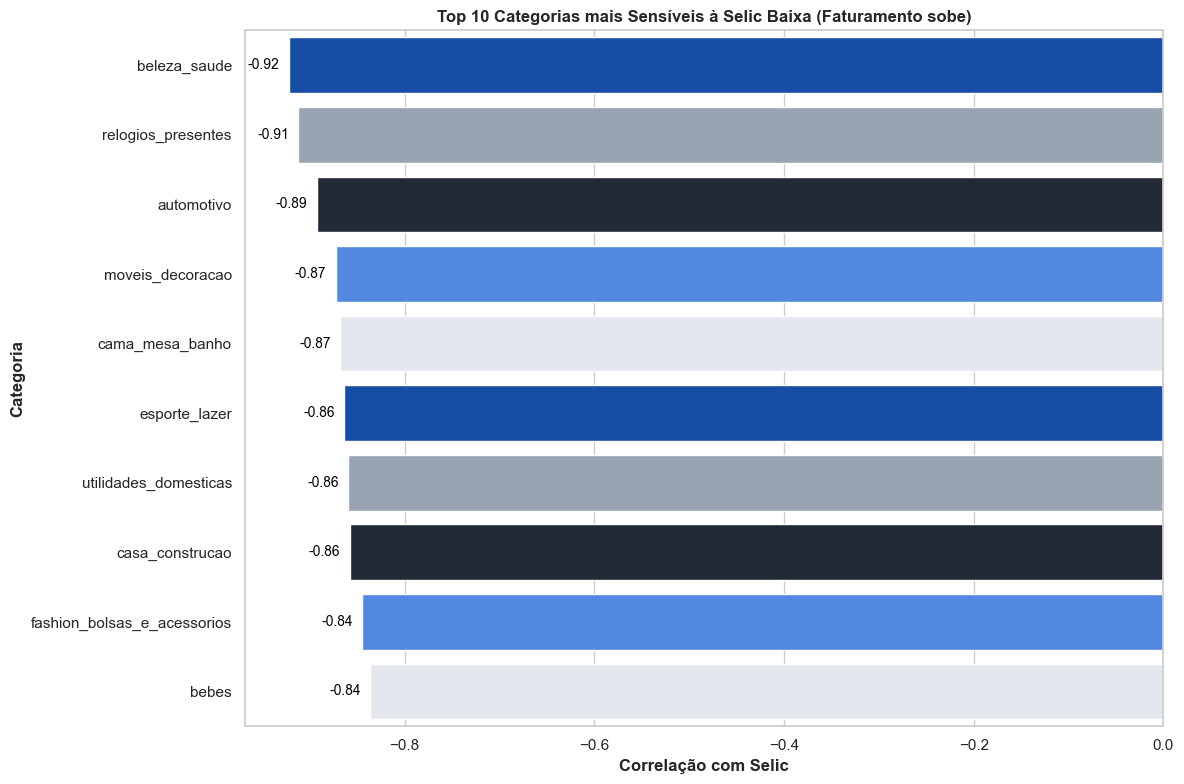

In [40]:
# Top 10 categorias mais sensíveis à Selic caindo
top10_corr = corr_categoria_df.head(10)

plt.figure(figsize=(12,8))
ax = sns.barplot(
    x='Corr_Juros_Faturamento',
    y='Categoria',
    data=top10_corr,
    palette=PALETA_OLIST  # paleta do projeto
)

# Adiciona os valores das correlações no final de cada barra
for bar in ax.patches:
    width = bar.get_width()       # comprimento da barra
    y = bar.get_y() + bar.get_height()/2  # posição vertical central
    ax.text(
        width + 0.01 if width >= 0 else width - 0.01,  # ajusta para dentro ou fora da barra
        y,
        f"{width:.2f}",
        va='center',
        ha='left' if width >= 0 else 'right',
        fontsize=10,
        color='black'
    )

plt.title('Top 10 Categorias mais Sensíveis à Selic Baixa (Faturamento sobe)')
plt.xlabel('Correlação com Selic')
plt.ylabel('Categoria')
plt.tight_layout()
plt.show()


Observa-se que categorias de bens de consumo discricionário, como Beleza/ Saúde e Relógios/Presentes, apresentam maior sensibilidade à variação da Selic do que categorias de bens duráveis, como Automotivo e Móveis. Ou seja, quando os juros caem, os consumidores tendem a aumentar mais o gasto em produtos não essenciais e de maior valor percebido.